In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from category_encoders import OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [100]:
#Create a wrangle function for the dataset
def wrangle(filepath):
    df = pd.read_csv(filepath).set_index("building_id")

    #Subset to houses in district 36
    mask_district = df["district_id"] == 36
    df = df[mask_district]

    #Remove leaky columns
    drop_col = [col for col in df.columns if "post" in col]

    # Create a binary classification of the damage grade: 1-3 = 0 and 4 - 5 = 1
    df["damage_grade"] = (df["damage_grade"].str[-1].astype(int) > 3).astype(int)

    #Remove low and high cardinal columns
    drop_col.append("district_id")

    #Drop highly correlated feature
    drop_col.append("count_floors_pre_eq")
    
    #Drop columns
    df.drop(columns = drop_col, inplace = True)

    return df

df = wrangle("NepalEarhquakeDamage2015.csv")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,damage_grade
building_id,,,,,,,,,,,
360106001171,4,280,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1
360106001181,15,120,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Attached-1 side,Rectangular,1
360107000161,25,300,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1
360107000381,22,155,16,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1
360202000691,20,240,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Brick/Stone,TImber/Bamboo-Mud,Attached-1 side,Rectangular,1


In [101]:
# Check major and minor class groups
major, minor = df["damage_grade"].value_counts(normalize = True).round(2)
major, minor

(0.64, 0.36)

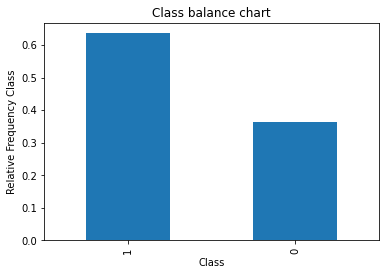

In [102]:
# Plot a balanced chart
df["damage_grade"].value_counts(normalize = True).plot(kind = "bar")
plt.title("Class balance chart")
plt.xlabel("Class")
plt.ylabel("Relative Frequency Class");

In [103]:
# Print correlations
corr = df.select_dtypes("number").drop(columns = "damage_grade").corr()
corr

,age_building,plinth_area_sq_ft,height_ft_pre_eq
age_building,1.000000,-0.019476,0.047666
plinth_area_sq_ft,-0.019476,1.000000,0.286794
height_ft_pre_eq,0.047666,0.286794,1.000000


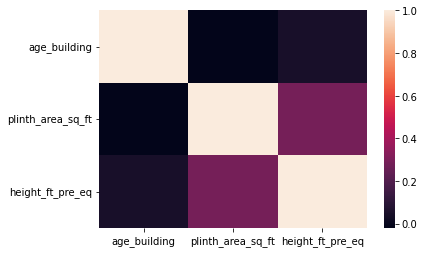

In [104]:
# Visualize correlation
corr = df.select_dtypes("number").drop(columns = "damage_grade").corr()
sns.heatmap(corr);

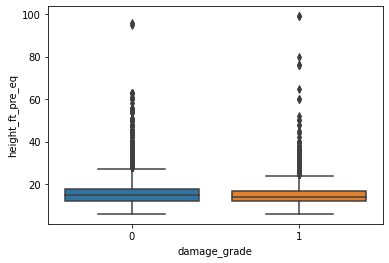

In [105]:
# Visualize one of the features using a seaborn boxplot
sns.boxplot(x = "damage_grade", y = "height_ft_pre_eq", data = df);

In [106]:
# Check foundation types using a pivot table
foundation_type = pd.pivot_table(
    df,
    values = "damage_grade",
    index = "foundation_type",
    aggfunc = np.mean
).sort_values("damage_grade")
foundation_type

,damage_grade
foundation_type,
RC,0.027134
Bamboo/Timber,0.321429
Cement-Stone/Brick,0.410200
Mud mortar-Stone/Brick,0.684101
Other,0.801020


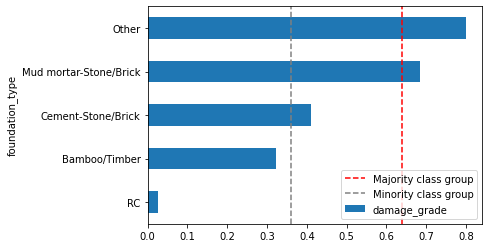

In [107]:
# Visualize foundation type
foundation_type.plot(kind = "barh");
plt.axvline(
    major, linestyle = "--",color = "red", label = "Majority class group"
)
plt.axvline(
    minor, linestyle = "--",color = "gray", label = "Minority class group"
)
plt.legend(loc="lower right");

In [108]:
# Check columns with high cardinality
df.select_dtypes("object").nunique()

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
dtype: int64

In [109]:
# Vertical split
target = "damage_grade"
X = df.drop(columns = target)
y = df[target]

In [110]:
# Randomized split of test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 20
)

In [111]:
# Validation split of test data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size = 0.2, random_state = 20
)

In [112]:
# Calculate accuracy score of test data
acc_score = y_train.value_counts(normalize=True).max()
print("Training accuracy score:",round(acc_score,2))

Training accuracy score: 0.64


In [113]:
# Build model
model = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state = 20)
)
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'data_type': dtype('O'...
                                          'data_type': dtype('O'),
                                          'mapping': Attached-1 side    1
Not attached       2
Attached-2 side    3
Attached-3 side    4
NaN               -2
dtype: int64},
                                         {'col': 'plan_configuration',
                                          'data_type': dtype('O'),
                                          'mapping': Rectangular                         1
Square                              2
Multi-projected                     3
L-shape                             4
U-shape                             5
T-shape                             6
E-shape                             7
Others                              8
H-shape                             9
Building with Central Courtyard    10
NaN                                -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=20))])

In [114]:
y_pred = model.predict_proba(X_train)[:,-1]
y_pred

array([1., 0., 1., ..., 1., 1., 0.])

In [115]:
print("Validation accuracy score:",round(model.score(X_val, y_val),2))

Validation accuracy score: 0.64


In [116]:
# Check max depth
max_depth = model.named_steps["decisiontreeclassifier"].get_depth()
max_depth

52

In [117]:
# Tune the hyperparameters
train_acc_scores = []
val_acc_scores = []
for depth in range(1, max_depth, 2):
    model_lr = make_pipeline(OrdinalEncoder(), DecisionTreeClassifier(random_state = 20, max_depth=depth))
    model_lr.fit(X_train, y_train)
    train_acc_scores.append(model_lr.score(X_train,y_train))
    val_acc_scores.append(model_lr.score(X_val,y_val))

In [118]:
# Print the accuracy scores
print(train_acc_scores[:5])
print(val_acc_scores[:5])

[0.689575119578922, 0.702743810915204, 0.7048852242480037, 0.7125102567694679, 0.7218964516580944]
[0.6936439321165546, 0.7052513608709574, 0.7088536663464617, 0.7118956131924432, 0.7135766890810118]


In [119]:
depth_params = range(1, max_depth, 2)

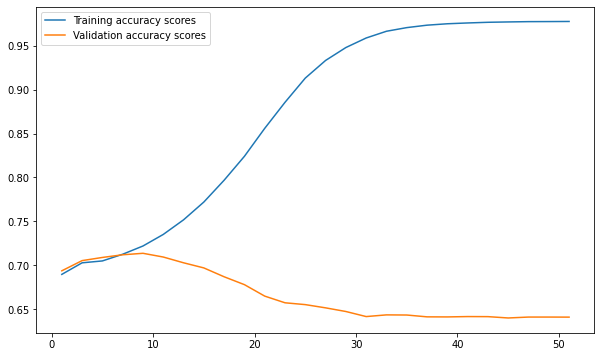

In [120]:
# Create a line plot for the accuracy scores to get the best max depth
fig, ax = plt.subplots(figsize = [10, 6])
plt.plot(depth_params, train_acc_scores, label = "Training accuracy scores")
plt.plot(depth_params, val_acc_scores, label = "Validation accuracy scores")
plt.legend();

In [121]:
# Rebuild model
model_final = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state = 20, max_depth = 9)
)
model_final.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'data_type': dtype('O'...
                                          'mapping': Attached-1 side    1
Not attached       2
Attached-2 side    3
Attached-3 side    4
NaN               -2
dtype: int64},
                                         {'col': 'plan_configuration',
                                          'data_type': dtype('O'),
                                          'mapping': Rectangular                         1
Square                              2
Multi-projected                     3
L-shape                             4
U-shape                             5
T-shape                             6
E-shape                             7
Others                              8
H-shape                             9
Building with Central Courtyard    10
NaN                                -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=9, random_state=20))])

In [122]:
print("Test accuracy score:",round(model_final.score(X_test, y_test),2))

Test accuracy score: 0.71


In [123]:
# Generate predictions
y_pred = model_final.predict_proba(X_train)[:,-1]
y_pred

array([0.60032232, 0.00765484, 0.80258303, ..., 0.72123552, 0.61284885,
       0.72506394])

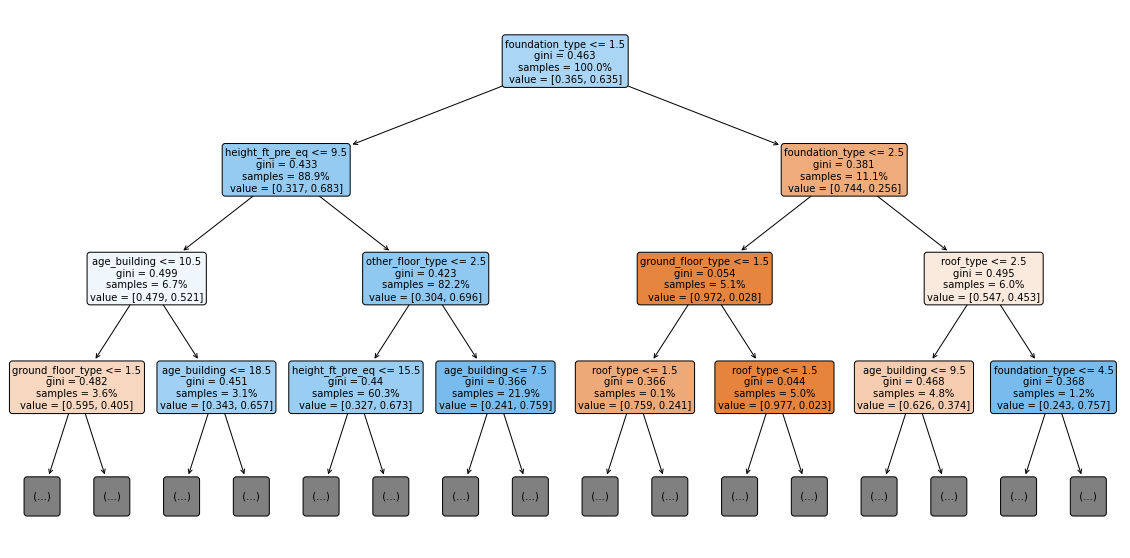

In [124]:
# Plot a decision tree
fig, ax = plt.subplots(figsize = [20, 10])
plot_tree(
    decision_tree = model_final.named_steps["decisiontreeclassifier"],
    feature_names = X_train.columns,
    max_depth = 3,
    rounded = True,
    filled = True,
    proportion = True,
    fontsize = 10,
);

In [125]:
importances = model_final.named_steps["decisiontreeclassifier"].feature_importances_
feat_imp = pd.Series(importances, index = X_train.columns).sort_values()
feat_imp[:5]

position                  0.008996
plan_configuration        0.009524
land_surface_condition    0.033936
other_floor_type          0.037128
roof_type                 0.054478
dtype: float64

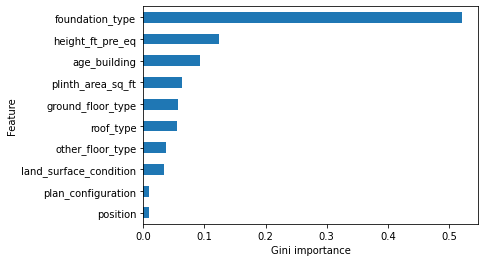

In [126]:
feat_imp.plot(kind = "barh")
plt.xlabel("Gini importance")
plt.ylabel("Feature");